# Введение: Автоматическая оптимизация гиперпараметров

В этом ноутбуке е мы рассмотрим автоматическую настройку гиперпараметров с помощью байесовской оптимизации. В частности, мы оптимизируем гиперпараметры Gradient Boosting Machine, используя библиотеку Hyperopt (с алгоритмом оценки Tree Parzen Estimator). Мы сравним результаты случайного поиска (реализованного вручную) для настройки гиперпараметров с методом оптимизации основанной на байесовской модели, чтобы попытаться понять, как работает байесовский метод и какие преимущества он имеет по сравнению со случайными методами поиска.

## Hyperopt

Hyperopt - одна из нескольких библиотек автоматического подбора гиперпараметров, использующих байесовскую оптимизацию. Эти библиотеки различаются по алгоритму, используемому как для создания surrogate (вероятностной модели) целевой функции, так и для выбора следующих гиперпараметров для оценки в целевой функции. Hyperopt использует Tree Parzen Estimator (TPE). Другие библиотеки Python включают Spearmint, который использует гауссовский процесс для surrogate, и SMAC, который использует регрессию случайного леса.

Hyperopt имеет простой синтаксис для структурирования задачи оптимизации, распространяющийся на настройку гиперпараметров для любой проблемы, включающей в себя минимизацию функции. Более того, структура задачи байесовской оптимизации одинакова во всех библиотеках, с основными различиями в синтаксисе (и в алгоритмах под капотом, с которыми мы не будем иметь дело).

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Данные

В этом ноутбуке мы будем работать с датасетом Caravan Insurance Challenge  [взятым с Kaggle](https://www.kaggle.com/uciml/caravan-insurance-challenge). Обучая модель на прошлых данных, нужно определить, будет ли потенциальный клиент покупать страховой полис. Это простая задача классификации машинного обучения с учителем: мы хотим обучить модель на прошлых данных, для прогнозирования бинарного результата на тестовых данных.

In [2]:
# Read in data and separate into training and testing sets
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


#### Распределение меток

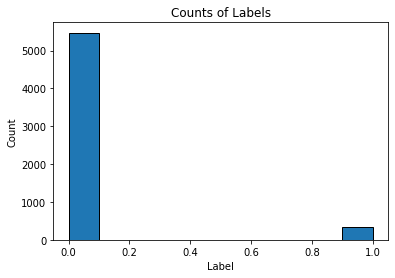

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

Это задача с несбалансированными классами: гораздо больше наблюдений, когда страховой полис не был куплен (0), чем когда он был куплен (1). Следовательно, точность - плохая метрика для этой задачи. Вместо этого мы будем использовать обычную кассификационную метрику ROC AUC. Случайное угадывание в задаче классификации даст ROC AUC 0.5, а идеальный классификатор даст ROC AUC 1.0. Для лучшей базовой модели, чем случайное угадывание, мы можем обучить Gradient Boosting Machine по умолчанию и делать прогнозы с ее помощью.

### Модель по умолчанию Gradient Boosting Machine

Мы будем использовать LightGBM-реализацию gradient boosting machine. Это намного быстрее, чем реализация Scikit-Learn, и дает результаты, сравнимые с extreme gradient boosting, XGBoost. Для базовой модели мы будем использовать гиперпараметры по умолчанию,  указанные в LightGBM.

In [4]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Все, что нам нужно сделать, это обучить модель на тренировочных данных и сделать прогнозы на тестовых. Поскольку мы измеряем ROC AUC, а не точность, мы будем использовать для прогнозов предсказанные моделью вероятности, а не жесткие двоичные значения.

In [5]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('Результат базовой модели на тестовых данных равен {:.4f}.'.format(auc))
print('Время обучения тестовой модели равно {:.4f} секунды'.format(train_time))


Результат базовой модели на тестовых данных равен 0.7092.
Время обучения тестовой модели равно 0.1975 секунды


Это метрики которые нам нужно улучшить. Из-за небольшого размера набора данных (менее 6000 наблюдений) настройка гиперпараметров окажет умеренное, но заметное влияние на качество модели (большего эффекта можно добиться собрав больше данных!)

# Случайный поиск

Сначала мы реализуем обычный метод оптимизации гиперпараметров: случайный поиск. На каждой итерации мы выбираем случайный набор гиперпараметров модели из пространства поиска. Эмпирически случайный поиск очень эффективен, он дает близкие к поиску по сетке результаты, при этом значительно сокращая время, затрачиваемое на поиск. Однако это все еще неинформированный метод в том смысле, что он не использует прошлые оценки целевой функции для информирования при выборе, который он делает для следующей оценки.

Случайный поиск состоит из следующих четырех частей, которые также используются в байесовской оптимизации гиперпараметров:

1. Область определения: диапазоны значений в которых происходит поиск
2. Алгоритм оптимизации: случайно выбираем следующее значение! (да это квалифицируется как алгоритм)
3. Минимизируемая целевая функция: в нашем случае это кросс валидация ROC AUC
4. История результатов которая отслеживает попытки выбора гиперпараметров и кросс-валидационную метрику.

Случайный поиск может быть реализован в библиотеке Scikit-Learn с использованием `RandomizedSearchCV`, однако, поскольку мы используем раннюю остановку (для определения оптимального числа оценщиков), мы реализуем этот метод самостоятельно (больше практики!). Это довольно просто, и многие идеи случайного поиска будут использованы в байесовской оптимизации гиперпараметров. 

In [6]:
import random

## Область определения для случайного поиска

И случайный поиск и байесовкая опимизация ищут гиперпараметры в некоторой области. Для случайного (или поиска по сетке) эта область называется сетка гиперпараметров и использует дискретные значения для гиперпараметров.

Сперва взглянем на все гиперпараметры которые нужно настроить.

In [7]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

На основе значений по умолчанию мы можем построить следующую сетку гиперпараметров. Сложно сказать заранее, какой выбор будет работать лучше, поэтому мы будем использовать широкий диапазон значений центрированный относительно значения по умолчанию для большинства гиперпараметров.

`subsample_dist` будет использован для `subsample` параметра, но мы не можем добавить его в сетку параметров поскольку `boosting_type=goss` не поддерживает подвыборку строк. Поэтому мы будем использовать оператор `if` при выборе наших гиперпараметров, чтобы выбрать пропорцию подвыборки если тип бустинга не  `goss`.

In [8]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

Давайте рассмотрим два распределения: learning_rate и num_leaves. Скорость обучения обычно [представлена логарифмическим распределением](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning), поскольку она может варьироваться в пределах нескольких порядков. np.logspace возвращает значения, равномерно распределенные по логарифмической шкале (поэтому, если мы возьмем логарифм результатов, распределение будет равномерным).

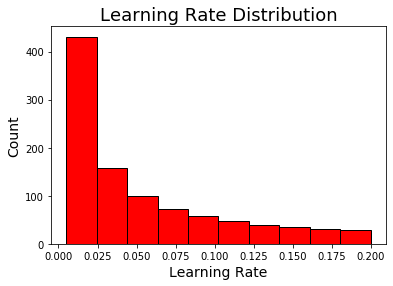

In [9]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

Меньшие значения скорости обучения чаще встречаются со значениями от 0,005 до 0,2. Диапазон области довольно велик, что указывает на большую неопределенность с нашей стороны относительно оптимального значения (которое, мы надеемся, находится где-то в сетке)!

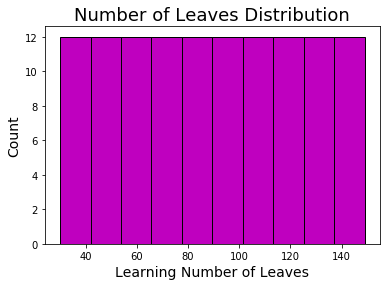

In [10]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

Количество листьев это обычная равномерная область

### Выборка из области определения гиперпараметра

Посмотрим как мы делаем выборку из множества гиперпараметров из нашей сетки используя понимание словаря (dictionary comprehension).

In [11]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 98,
 'learning_rate': 0.01945889745285081,
 'subsample_for_bin': 140000,
 'min_child_samples': 365,
 'reg_alpha': 0.5306122448979591,
 'reg_lambda': 0.5306122448979591,
 'colsample_bytree': 0.6}

Чтобы добавить долю `subsample` если `boosting_type` не `goss`, мы можем использовать оператор if.

In [12]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 98,
 'learning_rate': 0.01945889745285081,
 'subsample_for_bin': 140000,
 'min_child_samples': 365,
 'reg_alpha': 0.5306122448979591,
 'reg_lambda': 0.5306122448979591,
 'colsample_bytree': 0.6,
 'subsample': 0.7525252525252526}

Мы установим значение subsample равным 1.0 если вид бустинга - goss что значит что мы не используем подвыборки. (При использовании подвыборки мы обучаемся на подмножестве строк (наблюдений) а не на всем множестве данных. Эта техника также называется bagging для "bootstrap aggregating").

## Кросс-валидация с ранней остановкой в LightGBM

Кросс-валидация api scikit-learn не имеет опцию ранней остановки. Поэтому мы будем использовать функцию кросс-валидации LightGBM с 100 раундов ранней остановки. Для использования этой функции нам нужно создать датасет из наших признаков и меток.

In [13]:
# Создание lgb датасета
train_set = lgb.Dataset(features, label = labels)

Функция `cv` принимает параметры, обучающие данные, количество раундов обучения, количество фолдов, метрику, количество ранних остановок и несколько других аргументов. Мы установили количество раундов бустинга очень высоким, но на самом деле мы не будем обучать так много оценщиков, потому что мы используем раннюю остановку и прекращаем обучение, когда оценка валидации не улучшилась для 100 оценщиков.

In [14]:
# Выполняет кросс-валидацию с 10 фолдами
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Наибольший результат
r_best = np.max(r['auc-mean'])

# Стандартное отклонение наилучего результата
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('Максимальный ROC AUC на проверочных данных был {:.5f} с std равным {:.5f}.'.format(r_best, r_best_std))
print('Идеальное число итераций было {}.'.format(np.argmax(r['auc-mean']) + 1))

Максимальный ROC AUC на проверочных данных был 0.76305 с std равным 0.03632.
Идеальное число итераций было 249.


### Датафрейм результатов

У нас есть наши область и алгоритм, который в данном случае является случайным выбором. Две другие части, которые нам нужны для задачи оптимизации, - это целевая функция и структура данных для отслеживания результатов (эти же четыре части потребуются при байесовской оптимизации).

Отслеживание результатов будет осуществляться в `dataframe`, где в каждой строке будет храниться одна оценка целевой функции.

In [15]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Целевая функция

Целевая функция примет гиперпараметры и вернет потери на проверочных данных (вместе с некоторой другой информацией для отслеживания прогресса поиска). Мы уже выбрали в качестве метрики ROC AUC, и теперь нам нужно выяснить, как его измерить. Мы не можем оценить ROC AUC на тестовом наборе, потому что это будет обманом. Вместо этого мы должны использовать проверочный набор данных для настройки модели и надеяться, что результаты распространятся и на тестовое множество.

Вместо выделения проверочных данных из обучающей выборки (что ограничивает количество имеющихся у нас данных обучения), лучше использовать перекрестную проверку KFold. Помимо того что мы не уменьшаем обучающие данные, этот метод должен также дать нам лучшую оценку ошибки обобщения на тестовые данные, потому что мы будем использовать K проверок, а не только одну. В этом примере мы будем использовать 10-фолдовую кросс-валидацию, что означает тестирование и обучение каждого набора гиперпараметров модели 10 раз, каждый раз используя различные подмножества обучающих данных в качестве проверочной выборки. Целевая функция вернет список информации, включая валидационный AUC ROC. Мы также хотим сохранить используемые гиперпараметры, чтобы мы знали, какие из них являются оптимальными (или лучшими из тех, что мы пробовали).

В случае случайного поиска следующие выбранные значения не зависят от результатов прошлой оценки, но мы должны четко отслеживать их, чтобы знать, какие значения сработали лучше всего! Это также позволит нам сопоставить случайный поиск с информированной байесовской оптимизацией.

In [16]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Выполняет n_folds кросс-валидацию
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Потери должны быть минимизированы
    loss = 1 - best_score
    
    # Раунды бустинга возвращающие наибольший cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Возвращение списка результатов
    return [loss, params, iteration, n_estimators, end - start]

## Имплементация случайного поиска

Теперь мы можем написать цикл для итерации по количеству оценок, каждый раз выбирая для оценки различный набор гиперпараметров. При каждом прохождении функции результаты сохраняются в датафрейм. (Магия `%% capture` перехватывает любые выходные данные из ячейки в блокноте Jupyter. Это полезно, потому что выходные данные обучающего прогона LightGBM не могут быть заглушены).


In [17]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [18]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.232707,"{'class_weight': 'balanced', 'boosting_type': ...",292,161,5.76293
1,0.233449,"{'class_weight': None, 'boosting_type': 'dart'...",134,166,6.21474
2,0.234382,"{'class_weight': None, 'boosting_type': 'gbdt'...",369,295,8.94558
3,0.23443,"{'class_weight': None, 'boosting_type': 'gbdt'...",146,455,7.86373
4,0.234836,"{'class_weight': 'balanced', 'boosting_type': ...",284,115,5.64977


### Эффективность случайного поиска

Напомним, что базовая модель градиентного бустинга достигла результата 0.71 на тренировочных данных. Мы можем использовать лучшие параметры для случайного поиска и оценить их на тестовом множестве. 

Чему равны гиперпараметры вернувшие наибольший результат на целевой функции??

In [19]:
random_results.loc[0, 'params']

{'class_weight': 'balanced',
 'boosting_type': 'dart',
 'num_leaves': 64,
 'learning_rate': 0.0600116605611819,
 'subsample_for_bin': 240000,
 'min_child_samples': 255,
 'reg_alpha': 0.7959183673469387,
 'reg_lambda': 0.8163265306122448,
 'colsample_bytree': 0.6444444444444444,
 'subsample': 0.7070707070707071}

Ключ `estimators` содержит среднеее число оценщиков обученных с ранней остановкой (усредненные относительно 10 фолдов). Мы можем использовать это как оптимальное число оценщиков в модели градиентного бустинга.

In [20]:
# Найдем лучшие параметры и число оценщиков
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Обучимся на тренировочных данных
best_random_model.fit(features, labels)

# Сделаем предсказания на тестовых данных
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('Лучшая модель из результатов случайного поиска на тестовых данных {:.4f}.'.format(roc_auc_score(test_labels, predictions)))
print('Это было достигнуто используя {} поисковых итераций.'.format(random_results.loc[0, 'iteration']))

Лучшая модель из результатов случайного поиска на тестовых данных 0.7251.
Это было достигнуто используя 292 поисковых итераций.


Скромное улучшение по сравнению с базовым уровнем. Использование большего количества оценок может увеличить результат, но за счет увеличения времени оптимизации. Мы также должны помнить, что гиперпараметры оптимизированы на проверочных данных, что может не сработать на тестовых.

Сейчас мы можем перейти к байесовским методам и посмотреть можно ли на них получить лучшие результаты.

# Байесовская оптимизация гиперпараметров с использованием Hyperopt

Для байесовской оптимизации нам нужны следующие 4 пункта:

1. Целевая функция
2. Пространство определения значений
3. Алгоритм оптимизации гиперпараметров
4. История результатов

Мы уже использовали все это в случайном поиске, но для Hyperopt мы сделаем несколько изменений

## Целевая функция

Эта целевая функция все еще принимает на вход гиперпараметры, но она возвращает не список, а словарь. Единственное требование для целевой функции в Hyperopt это то, что она должна иметь в возвращаемом словаре ключ `"loss"`  для минимизации и ключ называемый `"status"` указывающий на то, что выполнение было успешно.

Если мы хотим отслеживать число итераций, мы можем объявить глобальную переменную `ITERATION` которая увеличивается при каждом вызове функции. Кроме того для получения подробных результатов, каждый раз когда выполняется функция, мы будем писать результаты в новую строку csv файла. Это может быть полезно для очень долгих вычислений, если мы хотим проверять прогресс (это может быть не самое элегантное решение, но оно лучше чем выводить результаты в консоль, поскольку в нашем случае мы их сохраняем!) 

Наиболее важной частью этой функции является то, что нам сейчас нужно вернуть __value to minimize__ а не сырой ROC AUC. Мы пытаемся найти лучшее значение целевой функции, и хоть больший ROC AUC лучше, Hyperopt может только минимизировать функцию. Поэтому простое решение - возвращать 1 - ROC (мы делали это и для случайного поиска в качестве практики).

In [21]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Целевая функция для оптимизации гиперпараметров Gradient Boosting Machine"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Получение подвыборки если небоходимо, иначе установка 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Получение типа бустинга
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Убедимся что параметры которые должны быть целочисленны - целочисленны
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Выполним n_folds кросс-валидацию
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Получим лучший результат
    best_score = np.max(cv_results['auc-mean'])
    
    # Потери должны быть минимизированы
    loss = 1 - best_score
    
    # Раунды бустинга возвращающие наибольший cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Запишем в csv ('a' значит append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Словарь с информацией для выполнения
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

Хотя Hyperopt-у нужен только `loss`, хорошо бы отслеживать и другие метрики, чтобы мы могли проверить результаты. Позже мы можем сравнить последовательности поисков с двух подходов, что поможет нам понять как работает метод. 

## Пространство области определения

Указание области определения (называемой `space` в Hyperopt) немного сложнее чем при поиске по сетке. В Hyperopt и других фреймворках байесовской оптимизации, область определения является не дискретной сеткой, а вмето этого имеет вероятностные распределения для каждого гиперпараметра.  Для каждого гиперпараметра мы будем использовать те же ограничения, что и для сетки, но вместо определения в каждой точке область представляет вероятности для каждого гиперпараметра. Это, вероятно, станет яснее в коде и изображениях!

In [22]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

Сначала мы рассмотрим пример скорости обучения. Опять же, мы используем лог-равномерное пространство для скорости обучения, определенной от 0,005 до 0,2 (так же, как и в сетке случайного поиска). На этот раз, когда мы строим график области, точнее увидеть график оценки плотности ядра, чем гистограмму (хотя оба показывают распределение).

In [23]:
# Созадим скорость обучения
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

Мы можем визуализировать скорость обучения сделав выборку из простанства используя утилиту Hyperopt. Здесь выборка из 10000 элементов.

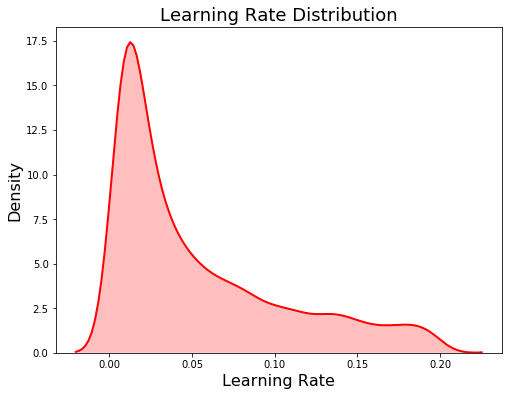

In [24]:
learning_rate_dist = []

# Нарисуем 10000 значений из области определения скорости обучения
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

Число листьев снова из равномерного распределения. Здесь мы использовали `quniform` являющийся дискретным равномерным (в противоположность непрерывному).

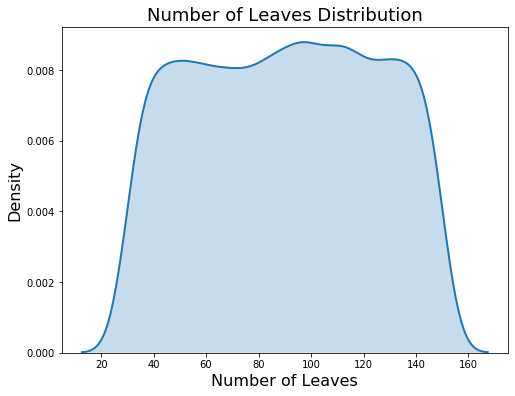

In [26]:
# Дискретное равномерное распределение
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Выберем 10000 раз из распределения количества листьев
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Условная область определения

В Hyperopt, мы можем использовать вложенные условные операторы для указания гиперпараметров зависящих от других гиперпараметров. Например, мы знаем что вид бустинга `goss` не может использовать подвыборку, так что мы устанавливаем `boosting_type` категорийной переменной, нам нужно установить `subsample` равным 1.0 в то время как для остальных видов бустинга это переменная с плавающей точкой между 0.5 и 1.0. Давайте посмотрим на пример:

In [27]:
# область определения видов бустинга 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# получим пример
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.5109276998231944}}

Нам нужно установить `boosting_type` и `subsample` ключами верхнего уровня в словаре параметров. Мы можем использовать метод  Python `dict.get` со значением по умолчанию равным 1.0. Это значит, что если ключ не представлен в словаре, возвращаемое значение по умолчанию будет равно (1.0).

In [28]:
# Получим подвыборку или установим значение равным 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Извлечем вид бустинга
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'gbdt', 'subsample': 0.5109276998231944}

Поскольку gbm не может использовать вложенный словарь, мы должны установить `boosting_type` и` subsample` в качестве ключей верхнего уровня. Вложенные условные выражения позволяют нам использовать разный гиперпараметров зависящий от других гиперпараметров. Например, мы можем исследовать разные модели с совершенно разными наборами гиперпараметров, используя вложенные условные выражения. Единственное требование заключается в том, что первый вложенный оператор должен основываться на гиперпараметре `choice` (выбор может быть типом модели).

## Полная байесовская область определения

Сейчас мы можем задать всю область. У каждой переменной должна быть метка и несколько параметров определяющих тип и размер распределения. Для таких переменных как вид бустинга, являющихся категорийными, мы используем переменную `choice`. Другие виды переменных включают `quniform`, `loguniform`, и `uniform`. Для полного списка проверьтеFor the complete [документацию](https://github.com/hyperopt/hyperopt/wiki/FMin)  Hyperopt. 

In [29]:
# Определим пространство поиска
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### Пример выборки из области определения

Давайте сделаем выборку из области определения (используя условную логику), чтобы увидеть результат каждого вытягивания. Каждый раз, когда мы запускаем этот код, результаты меняются. (Снова обратите внимание, что нам нужно назначить ключи верхнего уровня для ключевых слов, понятных GBM).

In [32]:
# Выборка из полного пространства
x = sample(space)

# Условная логика для присвоения ключей верхнего уровня
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6094332596508892,
 'learning_rate': 0.03296425398288081,
 'min_child_samples': 385.0,
 'num_leaves': 108.0,
 'reg_alpha': 0.9397678183096474,
 'reg_lambda': 0.8997115745818368,
 'subsample_for_bin': 160000.0,
 'subsample': 0.9167479057382742}

In [34]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.9684704995221759,
 'learning_rate': 0.039733466280785765,
 'min_child_samples': 75.0,
 'num_leaves': 94.0,
 'reg_alpha': 0.9811728483333539,
 'reg_lambda': 0.2552454513114416,
 'subsample_for_bin': 200000.0,
 'subsample': 0.9401737867965276}

## Алгоритм оптимизации

Хотя это наиболее техническая часть байесовской оптимизации, определение алгоритма для использования в Hyperopt делается просто. Мы используем Tree Parzen Estimator (прочитайте про него [в этой статья](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)) который является одним из способов построения суррогатной функции и выбора следующих гиперпараметров для оценки. 

In [35]:
from hyperopt import tpe

# алгоритм оптимизации
tpe_algorithm = tpe.suggest

## История результатов

Последняя часть это история результатов. Здесь мы используем два метода чтобы убедиться, что мы зафиксировали все результаты:

1. Объект `Trials`, в котором хранится словарь, возвращаемый целевой функцией.
2. Запись в csv-файл каждой итерации

В случае с csv файлом мы можем также мониторить результаты проходящего эксперимента. (Однако не испоьзуйте Excel для открытия файла пока продолжается обучение. Вместо этого проверьте результаты с помощью `tail results/gbm_trials.csv` из bash или другой командной строки.

In [38]:
from hyperopt import Trials

# Отслеживаем результаты
bayes_trials = Trials()

Объект `Trials` будет хранить все, что возвращается целевой функцией в аттрибуте `.results`. Он также содержит и другую информацию из поиска, но мы возвращаем все что нам нужно из целевой функции. 

In [42]:
# Файл для соранения первых результатов
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

Каждый раз когда вызвана целевая функция, она запишет одну строку в этот файл. Запуск ячейки выше очистит файл.

## Байесовская оптимизация

У нас есть все что нужно чтобы запустить оптимизацию. Сперва мы объявим глобальную переменную которая сможет отслеживать число итераций. Затем мы вызовем `fmin` передав все что мы определили выше и максимальное число итерация для запуска.

In [43]:
from hyperopt import fmin

In [44]:
%%capture

# Глобальная переменная
global  ITERATION

ITERATION = 0

# Запуск оптимизации
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

Аттрибут `.results` объекта `Trials` обладает всей информацией о целевой функции. Если мы отсортируем это по меньшим потерям, мы сможем увидеть гиперпараметры показывающий лучший результат в терминах потерь на валидации. 

In [45]:
# Сначала отсортируем испытания с наименьшими потерями (наибольший AUC)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.23200464220703432,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.620649129448606,
   'learning_rate': 0.017934544496484815,
   'min_child_samples': 260,
   'num_leaves': 30,
   'reg_alpha': 0.2092981310373776,
   'reg_lambda': 0.8946886330215067,
   'subsample_for_bin': 20000,
   'subsample': 0.8731487506937664},
  'iteration': 5,
  'estimators': 182,
  'train_time': 4.10171964399342,
  'status': 'ok'},
 {'loss': 0.23222162064361374,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.707810175151217,
   'learning_rate': 0.03508378068395589,
   'min_child_samples': 250,
   'num_leaves': 57,
   'reg_alpha': 0.36864183741796885,
   'reg_lambda': 0.65489943201357,
   'subsample_for_bin': 100000,
   'subsample': 0.8363541205295019},
  'iteration': 374,
  'estimators': 90,
  'train_time': 3.4594701360038016,
  'status': 'ok'}]

Мы можем также получить доступ к результатам из csv файла (что может быть проще так как это уже датафрейм).

In [46]:
results = pd.read_csv('results/gbm_trials.csv')

# Отсортируем по лучшим результатам вначели и сбросим индекс для среза
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.232005,"{'boosting_type': 'gbdt', 'class_weight': None...",5,182,4.101720
1,0.232222,"{'boosting_type': 'gbdt', 'class_weight': None...",374,90,3.459470
2,0.232335,"{'boosting_type': 'gbdt', 'class_weight': None...",344,117,3.670899
3,0.232597,"{'boosting_type': 'gbdt', 'class_weight': None...",272,156,3.213015
4,0.232618,"{'boosting_type': 'gbdt', 'class_weight': None...",495,142,3.459844


По некоторым причинам, когда мы сохраняем в файл и затем читаем обратно словарь гиперпараметров бывает представлен в виде строки. Чтобы конвертировать из строки обратно в словарь мы можем использовать библиотеку `ast` и функцию `literal_eval`.

In [47]:
import ast

# Конвертируем из строки в словарь
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.620649129448606,
 'learning_rate': 0.017934544496484815,
 'min_child_samples': 260,
 'num_leaves': 30,
 'reg_alpha': 0.2092981310373776,
 'reg_lambda': 0.8946886330215067,
 'subsample_for_bin': 20000,
 'subsample': 0.8731487506937664}

## Оцените лучшие результаты

Настал момент истины: окупилась ли оптимизация? Для этой проблемы с относительно небольшим набором данных преимущества оптимизации гиперпараметров по сравнению со случайным поиском, вероятно, незначительны (если таковые имеются). Случайный поиск может привести к лучшему результату за меньшее количество итераций просто из-за случайности!

In [48]:
# Получим идеальное число оценщиков и гиперпараметров
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Пересоздадим лучшую модель и обучим ее на тренировочных данных
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.620649129448606, importance_type='split',
               learning_rate=0.017934544496484815, max_depth=-1,
               min_child_samples=260, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=182, n_jobs=-1, num_leaves=30,
               objective='binary', random_state=50,
               reg_alpha=0.2092981310373776, reg_lambda=0.8946886330215067,
               silent=True, subsample=0.8731487506937664,
               subsample_for_bin=20000, subsample_freq=0)

In [49]:
# Оценим на тестовых данных
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72804 AUC ROC on the test set.
This was achieved after 5 search iterations


Байесовская оптимизация набрала чуть более высокие результаты ROC AUC на тестовых данных (здесь, в отличие от потерь, чем выше, тем лучше), но потребовалось и больше итераций для достижения лучшего результата (при повторном запуске ноутбука результаты могут измениться). Байесовская оптимизация также имеет лучшие результаты функции потерь при валидации (1 - ROC AUC), набрав 0.229 по сравнению с 0.231. Из-за небольших различий сложно сказать, что байесовская оптимизация лучше для этой конкретной проблемы. Как и с любой другой техникой машинного обучения, эффективность байесовской оптимизации будет зависеть от решаемой задачи. Для этой задачи мы видим небольшое преимущество, но также возможно, что случайный поиск может найти лучший набор гиперпараметров.

# Сравнение со случайным поиском

Сравнение результатов со случайным поиском в цифрах и графиках может помочь нам понять, как работает байесовская оптимизация поиска. Во-первых, посмотрим на лучшие гиперпараметры (по результатам ошибки валидации) из обоих поисков.

### Оптимальные гиперпараметры

Мы можем сравнить "лучшие" гиперпараметры найденные из обоих методов поиска. Интересно сравнить результаты поскольку они предполагают, что может быть несколько конфигураций дающих одинаковую валидационную ошибку.

In [50]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'
best_params = pd.DataFrame(best_bayes_params, index = [0]).append(pd.DataFrame(best_random_params, index = [0]), 
                                                                  ignore_index = True, sort = True)
best_params

,boosting_type,class_weight,colsample_bytree,learning_rate,method,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin
0,gbdt,None,0.620649,0.017935,Bayesian optimization,260,30,0.209298,0.894689,0.873149,20000
1,dart,balanced,0.644444,0.060012,random search,255,64,0.795918,0.816327,0.707071,240000


Верхний ряд - байесовская оптимизация, нижний - случайный поиск. 

## Визуализация гиперпараметров

Одна интересная вещь, которую мы можем сделать с результатами, состоит в том, чтобы посмотреть различные гиперпараметры, проверенные как случайным поиском, так и Tree Parzen Estimator. Поскольку случайный поиск выбирает безотносительно к предыдущим результатам, мы ожидаем, что распределение выборок должно быть близко к заданной нами области определения (оно не будет точным, поскольку мы используем довольно небольшое количество итераций). С другой стороны, оптимизация Байеса, если ей дано достаточно времени, должна сосредоточиться на «более перспективных» гиперпараметрах.

В дополнение к более концентрированному поиску, мы ожидаем, что средние валидационные потери байесовской оптимизации должны быть ниже, чем при случайном поиске, поскольку при этом выбираются значения, которые могут (в соответствии с вероятностной моделью) привести к меньшим потерям целевой функции. Потеря валидации при байесовском методе также должна уменьшаться с течением времени.

Сначала нам нужно извлечь гиперпараметры из обоих методов поиска. Мы будем хранить их в отдельных датафреймах.

In [51]:
# Создадим новый датафрейм для хранения параметров
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Добавим результаты каждого параметра в отдельную колонку
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

,class_weight,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,loss,iteration
0,balanced,dart,64,0.0600117,240000,255,0.795918,0.816327,0.644444,0.707071,0.232707,292
1,None,dart,103,0.0724473,80000,355,0.55102,0.0204082,0.6,0.575758,0.233449,134
2,None,gbdt,79,0.0118202,60000,260,0.571429,0.836735,0.6,0.666667,0.234382,369
3,None,gbdt,41,0.00694538,120000,255,0.591837,0.510204,0.644444,0.80303,0.23443,146
4,balanced,dart,72,0.106366,280000,280,0.591837,0.979592,0.644444,0.823232,0.234836,284


In [52]:
# Создадим новый датафрейм для хранения параметров
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Добавим результаты каждого параметра в отдельную колонку
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,loss,iteration
0,gbdt,None,0.620649,0.0179345,260,30,0.209298,0.894689,20000,0.873149,0.232005,5
1,gbdt,None,0.70781,0.0350838,250,57,0.368642,0.654899,100000,0.836354,0.232222,374
2,gbdt,None,0.609864,0.0249578,275,62,0.388201,0.829084,40000,0.500224,0.232335,344
3,gbdt,None,0.634744,0.0168265,270,36,0.663268,0.761796,180000,0.730699,0.232597,272
4,gbdt,None,0.627959,0.0218806,260,132,0.23021,0.393431,100000,0.764394,0.232618,495


#### Скорость обучения

Первый график показывает рапределение выборок подбора скорости обучения случайного поиска и байесовской оптимизации. 

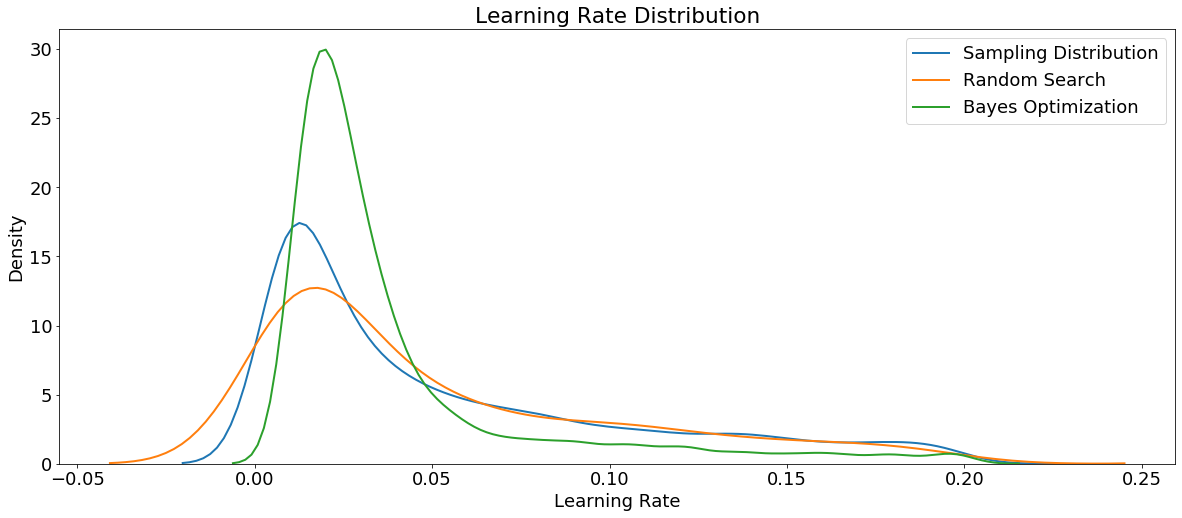

In [53]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Графики плотности распределений скорости обучения
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

#### Вид бустинга

Случайный поиск дожен использовать виды бустинга с одинаковой частотой. Однако, байесовская оптимизация может решить (смоделировать) что один из видов бустинга лучше другого для этой проблемы.

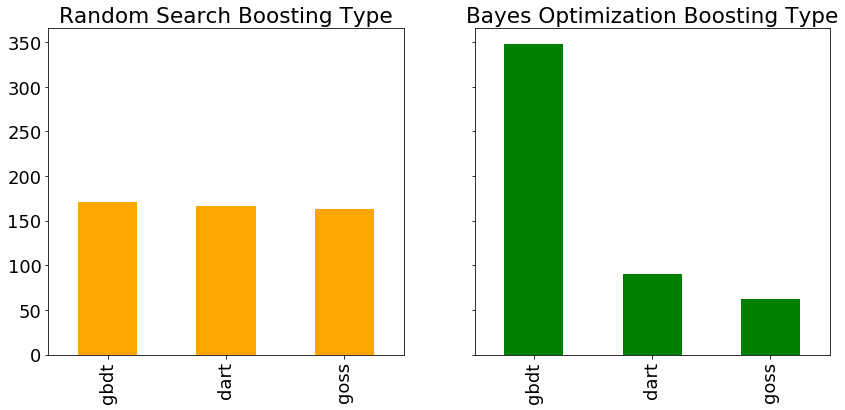

In [55]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Гистограммы видов бустинга
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [56]:
print('Процентовка видов бустинга при случайном поиске')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Процентовка видов бустинга при случайном поиске


goss    34.2
dart    33.2
gbdt    32.6
Name: boosting_type, dtype: float64

In [57]:
print('Процентовка видов бустинга при байесовской оптимизации')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Процентовка видов бустинга при байесовской оптимизации


gbdt    69.6
dart    18.0
goss    12.4
Name: boosting_type, dtype: float64

Байесовская оптимизация пробовала тип бустинга gradient boosted decision tree гораздо чаще, чем два других. Мы могли бы использовать эту информацию для последующего поиска лучших гиперпараметров, сосредоточившись на меньшей области поиска.

### Построим графики всех числовых гиперпараметров

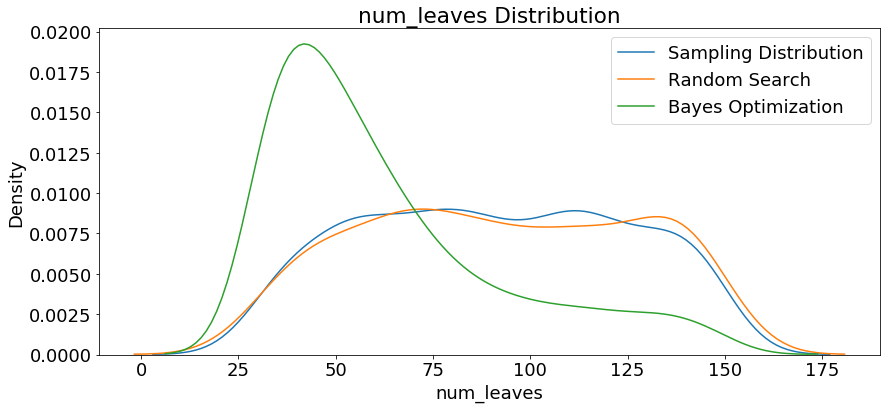

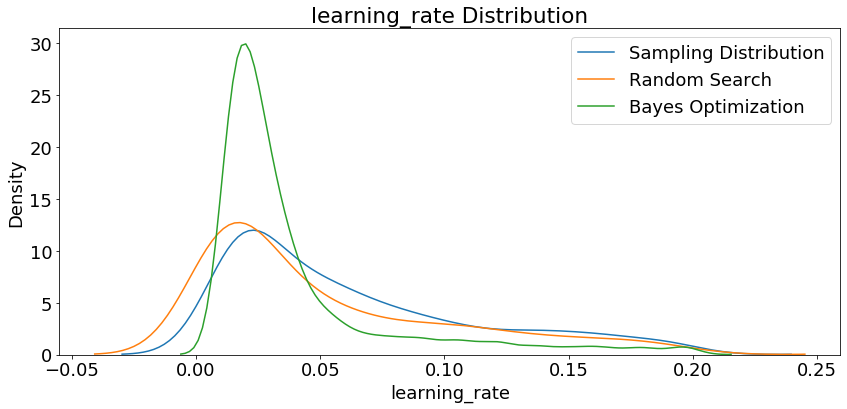

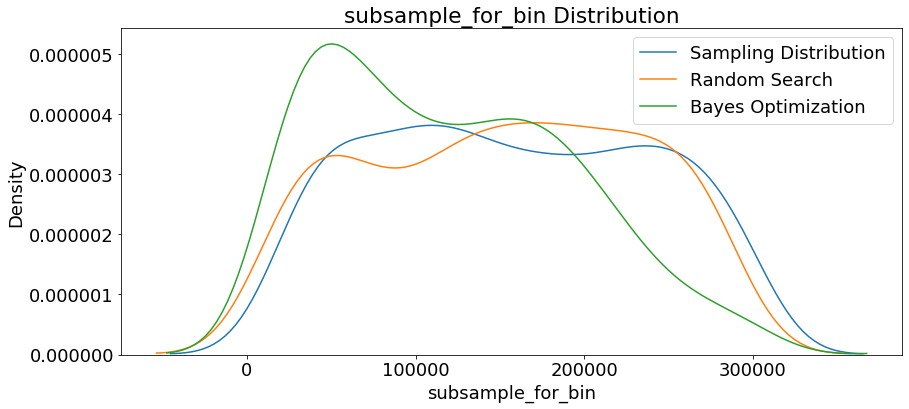

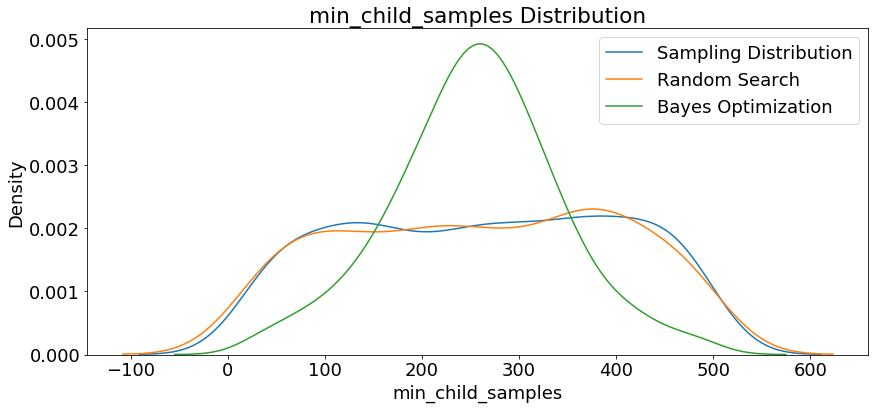

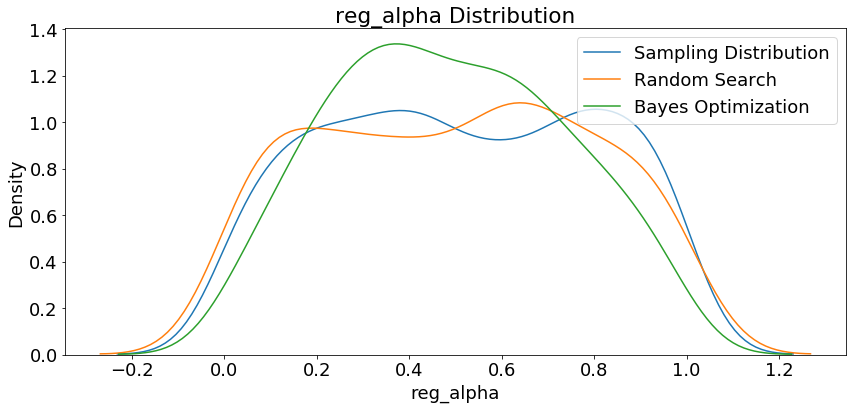

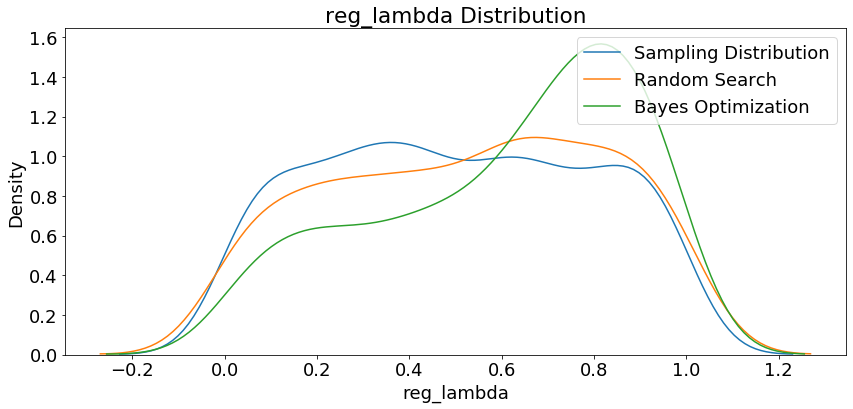

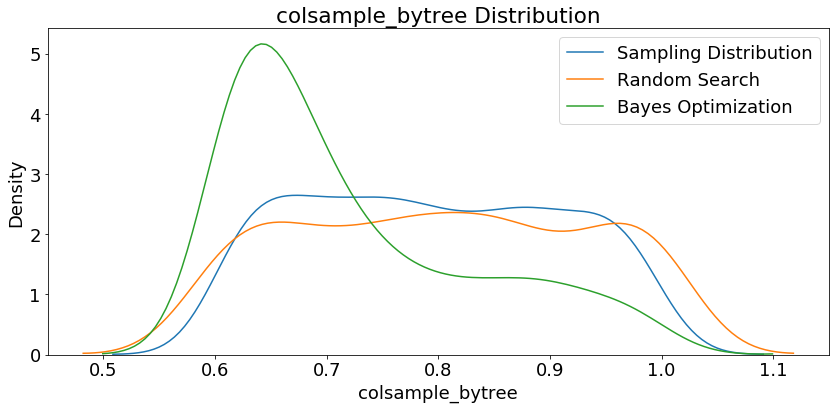

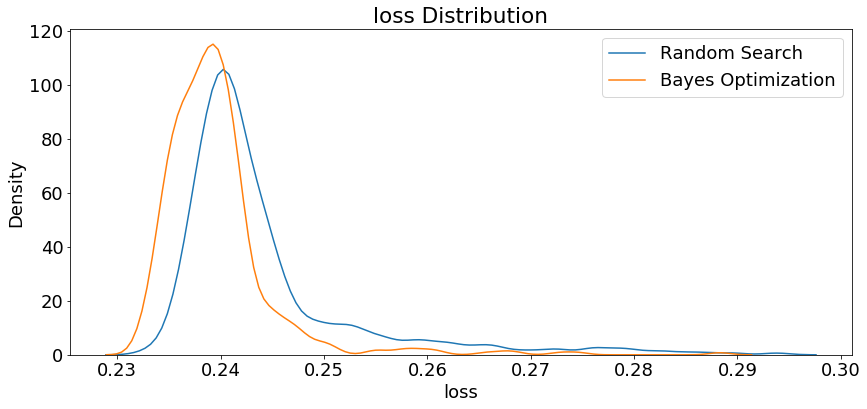

In [58]:
# Переберем все гиперпараметы
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Построим графики распределений при случайном поиске и байесовской оптимизации
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

Последний график показывает, что валидационные потери при байесовской оптимизации, как правило, ниже, чем при случайном поиске. Это должно вселить в нас уверенность, что метод работает правильно. Опять же, это не означает, что гиперпараметры, найденные во время байесовской оптимизации, обязательно лучше для тестовых данных, только то, что они дают меньшие потери при кросс-валидации.

## Эволюция поиска гиперпараметров

Мы также можем построить временной график гиперпараметров (зависящий от количества итераций), чтобы увидеть, как они меняются для байесовской оптимизации. Сначала мы присвоим `boosting_type` целые числа для построения графика.

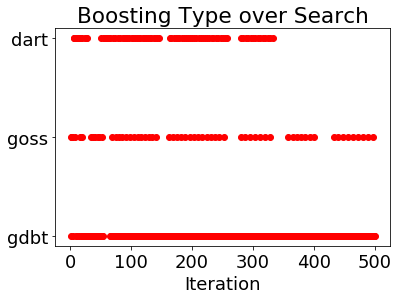

In [59]:
# Сопоставление видов бустинга целым числам (по существу, кодирование меток)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Построим график вида бустинга при случайном поиске

plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

Этот гиперпараметр со временем изменяется не сильно: `gdbt` доминирует на всем протяжении.

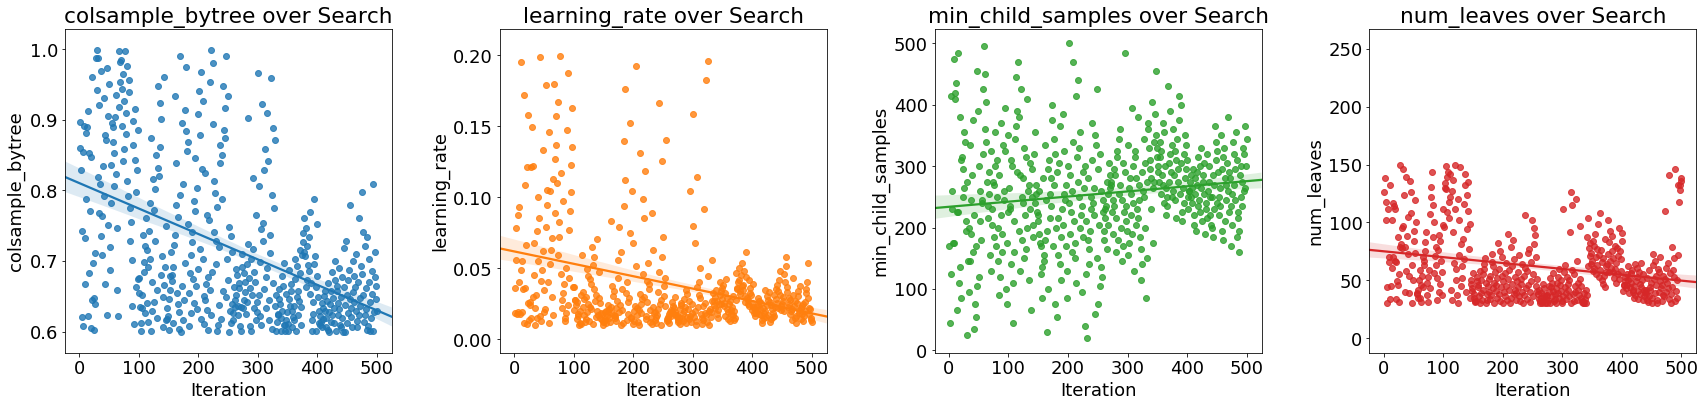

In [61]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Построить график четырех гиперпараметров
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

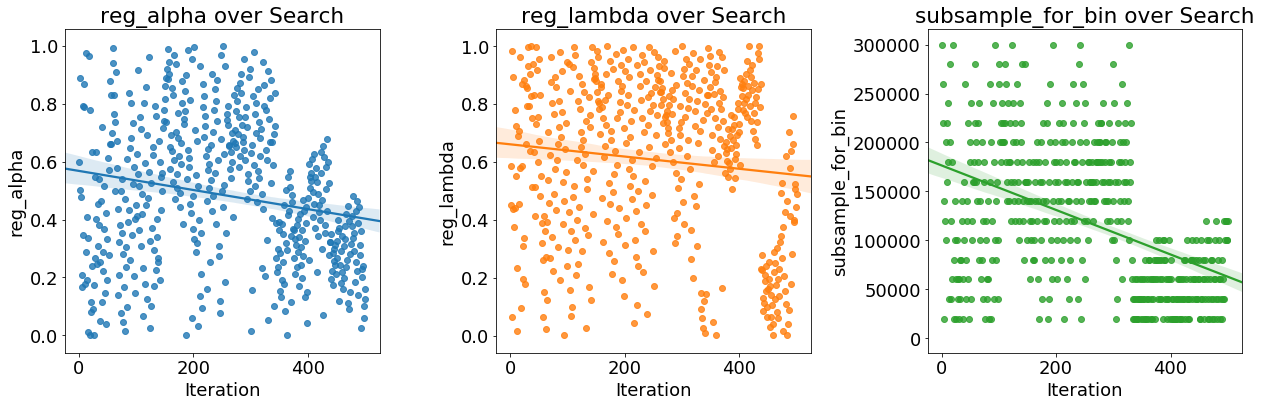

In [63]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot следующих трех гиперпараметров
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

Если на этих графиках есть тренды, мы можем использовать их для информирования последующих поисков. Возможно, мы даже захотим использовать поиск по сетке, фокусируясь на гораздо меньшей области гиперпараметра на основе результатов Байесовской оптимизации.

#### Потери при валидации

Наконец, мы можем посмотреть на потери как при случайном поиске, так и при байесовской оптимизации. Мы ожидаем, что средние потери, при байесовской оптимизацией, будут ниже, поскольку этот метод должен проводить больше времени в перспективных областях пространства поиска гиперпараметров.

In [64]:
# Датафрейм только результатов
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.767293,292,random
1,0.766551,134,random
2,0.765619,369,random
3,0.765570,146,random
4,0.765164,284,random


Мы можем построить гистограммы результатов (не учитывая итерацию) на одной и той же оси x, чтобы увидеть есть ли разница в результатах.

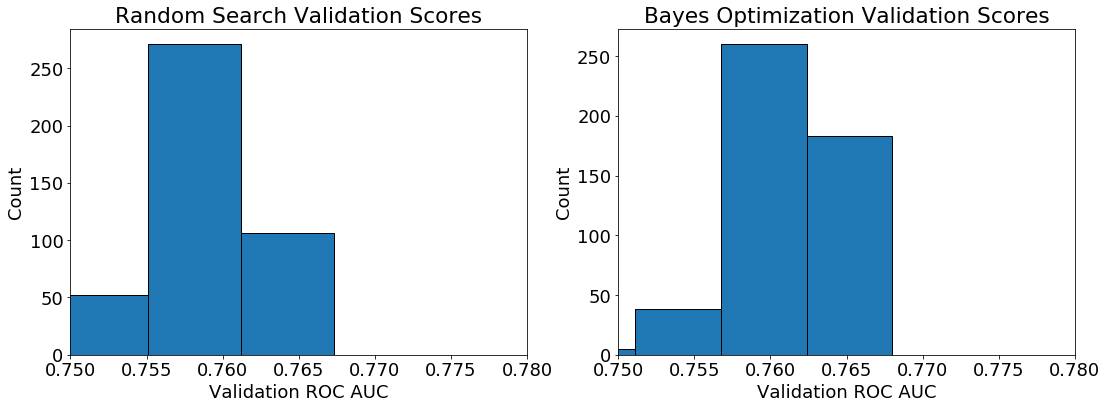

In [65]:
plt.figure(figsize = (18, 6))

# Результаты случайного поиска
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Результаты байесовской оптимизации
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

Похоже, что ROC AUC на проверочных данных для байесовской оптимизации выше, чем для случайного поиска. Однако, как мы видели, это не обязательно означает лучший результат тестирования!

Байесовская оптимизация должна улучшаться со временем. Давайте построим график результатов по итерациям, чтобы увидеть, было ли улучшение.

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


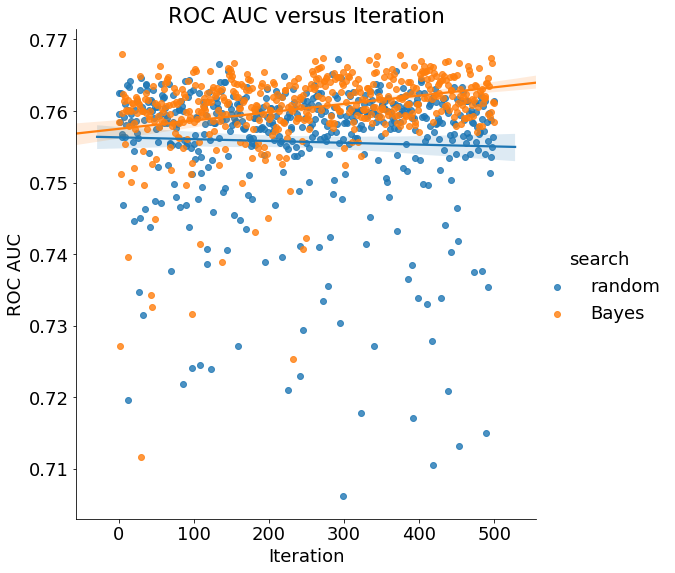

In [66]:
# График результатов по времени поиска
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

Обнадеживает, что результаты байесовской оптимизации ROC AUC на валидации со временем увеличиваются. Это показывает, что модель исследует гиперпараметры, которые лучше по метрике кросс-валидации! Было бы интересно продолжить поиск и посмотреть, есть ли плато в результатах валидации (должно быть в конечном итоге). Более того, даже если показатели валидации продолжают расти, это не означает лучшую модель для  тестовых данных!

Если мы хотим сохранить результаты испытаний мы можем выбрать формат json.

In [67]:
import json

# Сохраним результаты испытаний
with open('results/trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [68]:
# Сохраним датафреймы параметров
bayes_params.to_csv('results/bayes_params.csv', index = False)
random_params.to_csv('results/random_params.csv', index = False)

## Продолжим поиск

Мы можем продолжать поиск байесовских гиперпараметров большим количеством итераций, чтобы попытаться получить лучшие результаты. Hyperopt продолжит поиск там, где остановился, если мы [передадим ему объект испытаний, который уже имеет информацию о предыдущих запусках] (https://github.com/hyperopt/hyperopt/issues/267). Это влечет за собой хорошую практику: всегда сохраняйте свои предыдущие результаты, потому что вы никогда не знаете, когда они будут полезны!

Еще один интересный момент, который нужно отметить, заключается в том, что методы байесовской оптимизации не имеют внутреннего состояния, что означает, что все, что им нужно, - это результаты: предыдущие входные данные для целевой функции и получающиеся потери. На основании только этих результатов эти методы могут построить surrogate функцию и предложить следующий набор гиперпараметров для оценки. Внутренние элементы целевой функции не влияют на метод байесовской оптимизации, поэтому его называют методом оптимизации черным ящиком.

In [ ]:
# Продолжим обучения
ITERATION = MAX_EVALS + 1

# Увеличим количество итераций
MAX_EVALS = 1000

In [ ]:
%%capture

# Используем тот же объект испытаний чтобы продолжить обучение
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, rstate = np.random.RandomState(50))

In [ ]:
# Отсортируем результаты по возрастанию потерь (убыванию AUC)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [69]:
results = pd.read_csv('results/gbm_trials.csv')

# Отсортируем результаты поставив лучшие наверх и сбросим индекс для среза
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.232005,"{'boosting_type': 'gbdt', 'class_weight': None...",5,182,4.101720
1,0.232222,"{'boosting_type': 'gbdt', 'class_weight': None...",374,90,3.459470
2,0.232335,"{'boosting_type': 'gbdt', 'class_weight': None...",344,117,3.670899
3,0.232597,"{'boosting_type': 'gbdt', 'class_weight': None...",272,156,3.213015
4,0.232618,"{'boosting_type': 'gbdt', 'class_weight': None...",495,142,3.459844


In [ ]:
# Получим идеальное число оценщиков и гиперпараметров
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Пересоздадим лучшую модель и обучим ее на тренировочных данных
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [62]:
# Проверим мо
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72736 AUC ROC on the test set.
This was achieved after 846 search iterations


The continuation of the search did slightly improve the validation score (again depending on training run). Instead of training more, we might want to restart the search so the algorithm can spend more time exploring the domain space. As searching continues, the algorithm shifts from exploring (trying new values) to exploiting (trying those values that worked best in the past). This is generally what we want unless the model gets stuck in a local minimum at which point we would want to restart the search in a different region of the hyperparameter space. Bayesian Optimization of hyperparameters is still prone to overfitting, even when using cross-validation because it can get settle into a local minimum of the objective function. It is very difficult to tell when this occurs for a high-dimensional problem!

# Conclusions

In this notebook, we saw how to implement automated hyperparameter tuning with Bayesian Optimization methods. We used the open-source Python library Hyperopt with the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. 

Bayesian model-based optimization can be more efficient than random search, finding a better set of model hyperparameters in fewer search iterations (although not in every case). However, just because the model hyperparameters are better on the validation set does not mean they are better for the testing set! For this training run, Bayesian Optimization found a better set of hyperparamters according to the validation and the test data although the testing score was much lower than the validation ROC AUC. This is a useful lesson that even when using cross-validation, overfitting is still one of the top problems in machine learning. 

Bayesian optimization  is a powerful technique that we can use to tune any machine learning model, so long as we can define an objective function that returns a value to minimize and a domain space over which to search. This can extend to any function that we want to minimize (not just hyperparameter tuning). Bayesian optimization can be a significant upgrade over uninformed methods such as random search and because of the ease of use in Python are now a good option to use for hyperparameter tuning. As with most subjects in machine learning, there is no single best answer for hyperparameter tuning, but Bayesian optimization methods should be a tool that helps data scientists with the tedious but necessary task of model tuning! 